<a href="https://colab.research.google.com/github/nurfnick/Data_Viz/blob/main/Content/Data_Collecting/12_GatheringConclusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gathering Data Conclusion

At this point you should be able to gather data from:


*   A CSV or Excel file
*   SQL databases
*   HTML tables
*   Twitter

From all that data that you have gathered you should be able to do some basic manipulations on it using pandas or sql langauge.

To prepare yourself for the exam, attempt the following problems:

1. Use the SQL table `bigquery-public-data.london_fire_brigade.fire_brigade_service_calls`
  1. How many entries are there in the dataset
  2. How many False Alarms happened between 10PM and 5 AM?
  3. What is the average number of num_pumps_attending when there is a Fire?
  4. What is the largest number of num_pumps_attending to a Road Vehicle property_category
  5. How many fires had more than average number of pumps attending?
2. Navigate to the Oklahoma wikipedia page.  Grab the table on tempuratures in largest cities.  I've included some code below for cleaning up that table.
  1. What is the average monthly high temperature for OKC?
  2. Create a plot of the average monthly low tempurature in Tulsa.
  3. Identify the city with the highest high tempurature in each month. 


Code for cleaning up table in #2 is below.  Make sure to scrape the table and call it `df`.

```
df = df.melt(id_vars = ['City','Unnamed: 1'],
                  value_vars = df.columns[2:],
                  var_name = 'month'
)

df.value = df.value.apply(lambda s: int(s[:2]))

df.columns = ['City','Low_High', 'Month','Temp_F']

df
````



## My Solutions

### SQL

In [ ]:


from google.colab import auth
auth.authenticate_user()
print('Authenticated')



Authenticated


How many total rows are there?

In [ ]:
%%bigquery --project pic-math
SELECT 
  COUNT(*) as total_rows
FROM `bigquery-public-data.london_fire_brigade.fire_brigade_service_calls`

,total_rows
0,32247


Here I am peaking at the data.

In [ ]:
%%bigquery --project pic-math
SELECT *
FROM `bigquery-public-data.london_fire_brigade.fire_brigade_service_calls`
LIMIT 10

,incident_number,date_of_call,cal_year,time_of_call,hour_of_call,timestamp_of_call,incident_group,stop_code_description,special_service_type,property_category,property_type,address_qualifier,postcode_full,postcode_district,borough_code,borough_name,proper_case,ward_code,ward_name,ward_name_new,easting_m,northing_m,easting_rounded,northing_rounded,frs,incident_station_ground,first_pump_arriving_attendance_time,first_pump_arriving_deployed_from_station,second_pump_arriving_attendance_time,second_pump_arriving_deployed_from_station,num_stations_with_pumps_attending,num_pumps_attending
0,000320-01012017,2017-01-01,2017,15:30:22,15,2017-01-01 15:30:22+00:00,False Alarm,AFA,None,Dwelling,Purpose Built Flats/Maisonettes - Up to 3 stor...,Within same building,None,IG9,E00000000,NOT GEO-CODED,Not geo-coded,E00000000,Not geo-coded,Not geo-coded,NaN,NaN,541450,194050,OverTheBorder,OverTheBorder,None,None,None,None,2,2
1,003727-09012017,2017-01-09,2017,10:41:54,10,2017-01-09 10:41:54+00:00,False Alarm,AFA,None,Dwelling,House - single occupancy,Correct incident location,None,IG7,E00000000,NOT GEO-CODED,Not geo-coded,E00000000,Not geo-coded,Not geo-coded,NaN,NaN,543650,192950,OverTheBorder,OverTheBorder,None,None,None,None,2,2
2,003762-09012017,2017-01-09,2017,12:28:39,12,2017-01-09 12:28:39+00:00,False Alarm,AFA,None,Dwelling,House - single occupancy,Correct incident location,None,IG7,E00000000,NOT GEO-CODED,Not geo-coded,E00000000,Not geo-coded,Not geo-coded,NaN,NaN,543650,192950,OverTheBorder,OverTheBorder,None,None,None,None,2,2
3,006403-16012017,2017-01-16,2017,04:02:14,4,2017-01-16 04:02:14+00:00,False Alarm,AFA,None,Dwelling,Purpose Built Flats/Maisonettes - Up to 3 stor...,Correct incident location,None,IG7,E00000000,NOT GEO-CODED,Not geo-coded,E00000000,Not geo-coded,Not geo-coded,NaN,NaN,544350,192250,OverTheBorder,OverTheBorder,None,None,None,None,2,2
4,010947-26012017,2017-01-26,2017,11:14:03,11,2017-01-26 11:14:03+00:00,False Alarm,AFA,None,Dwelling,House - single occupancy,Correct incident location,None,IG10,E00000000,NOT GEO-CODED,Not geo-coded,E00000000,Not geo-coded,Not geo-coded,NaN,NaN,542050,196450,OverTheBorder,OverTheBorder,None,None,None,None,1,1
5,014169-03022017,2017-02-03,2017,04:58:02,4,2017-02-03 04:58:02+00:00,False Alarm,AFA,None,Dwelling,Converted Flat/Maisonettes - 3 or more storeys,Correct incident location,None,TN14,E00000000,NOT GEO-CODED,Not geo-coded,E00000000,Not geo-coded,Not geo-coded,NaN,NaN,548750,157750,OverTheBorder,OverTheBorder,None,None,None,None,3,5
6,016263-08022017,2017-02-08,2017,09:47:05,9,2017-02-08 09:47:05+00:00,False Alarm,AFA,None,Dwelling,House - single occupancy,Correct incident location,None,IG7,E00000000,NOT GEO-CODED,Not geo-coded,E00000000,Not geo-coded,Not geo-coded,NaN,NaN,544150,192550,OverTheBorder,OverTheBorder,None,None,None,None,2,2
7,016865-09022017,2017-02-09,2017,18:40:43,18,2017-02-09 18:40:43+00:00,False Alarm,AFA,None,Non Residential,Warehouse,Correct incident location,UB9 5HJ,UB9,E00000000,NOT GEO-CODED,Not geo-coded,E00000000,Not geo-coded,Not geo-coded,504201.0,188280.0,504250,188250,OverTheBorder,OverTheBorder,None,None,None,None,1,1
8,017092-10022017,2017-02-10,2017,10:07:53,10,2017-02-10 10:07:53+00:00,False Alarm,AFA,None,Non Residential,Factory,Correct incident location,UB9 5HJ,UB9,E00000000,NOT GEO-CODED,Not geo-coded,E00000000,Not geo-coded,Not geo-coded,504287.0,188271.0,504250,188250,OverTheBorder,OverTheBorder,None,None,None,None,1,1
9,024609-27022017,2017-02-27,2017,09:34:33,9,2017-02-27 09:34:33+00:00,False Alarm,AFA,None,Dwelling,Converted Flat/Maisonette - Up to 2 storeys,Correct incident location,None,CR3,E00000000,NOT GEO-CODED,Not geo-coded,E00000000,Not geo-coded,Not geo-coded,NaN,NaN,537650,155050,OverTheBorder,OverTheBorder,None,None,None,None,1,1


To find 'False Alarms' between certain hours, I will use the `WHERE` command and join several clauses carefully with `AND` and `OR`

In [ ]:
%%bigquery --project pic-math
SELECT COUNT(*) as number_of_late_night_false_alarms
FROM `bigquery-public-data.london_fire_brigade.fire_brigade_service_calls`
WHERE incident_group = "False Alarm" AND (hour_of_call >= 22 OR hour_of_call <= 4)

,number_of_late_night_false_alarms
0,2825


If we want to see about when there is a fire, we will need to either restrict our data to then or possible `GROUP BY`  I think I'll use the group by since I already did one with the WHERE.

In [ ]:
%%bigquery --project pic-math
SELECT incident_group, AVG(num_pumps_attending) as avg_pumps_attending
FROM `bigquery-public-data.london_fire_brigade.fire_brigade_service_calls`
GROUP BY incident_group

,incident_group,avg_pumps_attending
0,False Alarm,1.725776
1,Fire,1.633012
2,Special Service,1.177192


### HTML

To navigate to the wikipedia page I'll need some other packages!

In [ ]:
import requests
import pandas as pa
from bs4 import BeautifulSoup


r = requests.get('https://en.wikipedia.org/wiki/Oklahoma')
html_contents = r.text
html_soup = BeautifulSoup(html_contents,"lxml")
tables = html_soup.find_all('table',class_="wikitable")

df = pa.read_html(str(tables))[0]


df = df.melt(id_vars = ['City','Unnamed: 1'],
                  value_vars = df.columns[2:],
                  var_name = 'month'
)

df.value = df.value.apply(lambda s: int(s[:2]))

df.columns = ['City','Low_High', 'Month','Temp_F']

df

,City,Low_High,Month,Temp_F
0,Oklahoma City,Avg. high,Jan,50
1,Oklahoma City,Avg. low,Jan,29
2,Tulsa,Avg. high,Jan,48
3,Tulsa,Avg. low,Jan,27
4,Lawton,Avg. high,Jan,50
...,...,...,...,...
67,Oklahoma City,Avg. low,Dec,31
68,Tulsa,Avg. high,Dec,49
69,Tulsa,Avg. low,Dec,30
70,Lawton,Avg. high,Dec,52


In [ ]:
df.describe()

,Temp_F
count,72.000000
mean,61.333333
std,19.325966
min,26.000000
25%,49.000000
50%,62.000000
75%,73.000000
max,96.000000


In [ ]:
df.query('City == "Oklahoma City" and Low_High == "Avg. high"').Temp_F.mean()

72.25

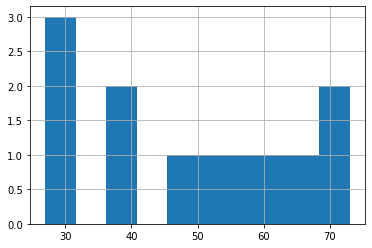

In [ ]:
df.query('City == "Tulsa" and Low_High == "Avg. low"').Temp_F.hist()

City
Lawton           AxesSubplot(0.125,0.125;0.775x0.755)
Oklahoma City    AxesSubplot(0.125,0.125;0.775x0.755)
Tulsa            AxesSubplot(0.125,0.125;0.775x0.755)
Name: Temp_F, dtype: object

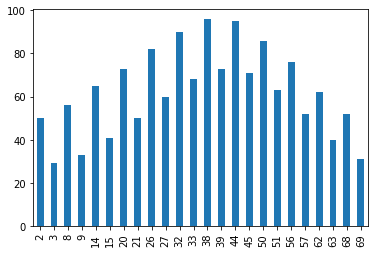

In [ ]:
df.groupby('City')['Temp_F'].plot(kind ='bar')

In [ ]:
df.query('Low_High == "Avg. high"').groupby('Month').agg(['mean','max'])

Temp_F    
            mean max
Month               
April  72.666667  73
Aug    93.666667  95
Dec    50.666667  52
Feb    54.666667  56
Jan    49.333333  50
July   94.333333  96
June   88.666667  90
March  63.333333  65
May    80.333333  82
Nov    61.666667  62
Oct    74.000000  76
Sept   85.000000  86

In [ ]:
df[df.Temp_F == df.groupby('Month').Temp_F.transform(max)]

,City,Low_High,Month,Temp_F
0,Oklahoma City,Avg. high,Jan,50
4,Lawton,Avg. high,Jan,50
10,Lawton,Avg. high,Feb,56
16,Lawton,Avg. high,March,65
18,Oklahoma City,Avg. high,April,73
22,Lawton,Avg. high,April,73
28,Lawton,Avg. high,May,82
34,Lawton,Avg. high,June,90
40,Lawton,Avg. high,July,96
46,Lawton,Avg. high,Aug,95
